# Preparation of Vectors for Model Training

The vectors to be used for training are combinations of politician info along with document information coming from articles written about these politicians.  

The politician features include:
- When they entered office
- When they left office?
- Their name?
- Party
- President
- Their Role

The document features include:
- Sentiment
- Frequency of publications in the current month (make a 30 day window?)
- Percent occupation of positive class topics (multiple features)
- Percent occupation of negative class topics (multiple features)
- Cluster that the doc belongs to after training Word2Vec model and clustering


In [1]:
from pymongo import MongoClient
import gensim
from gensim import corpora, models, similarities, matutils
from gensim.test.utils import datapath
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import dbscan, KMeans, mean_shift
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import random
import pickle
import datetime
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Load Data

In [2]:
df = pd.read_pickle('data/train_df.pkl')

wordnet_lemmatizer = WordNetLemmatizer()
text_lemmas = {}

db = MongoClient('localhost', 27017)['politician_db']
collection_names = df.collectionname

specific_stop_words = ['advertisement', 'sept','this','is','a','digitized','version',
                       'of','an','article','from','the','times','print','archive','before',
                       'the','start','online','publication','in','to','preserve','these',
                       'a','they','originally','appeared','time','doe','does','not','alter',
                       'edit','or','update','them','occasionally','digitization','process',
                       'introduces','transcription','error','other','problem','please','send',
                       'report', 'such','problem','archivefeedbacknytimescom']

chunks = [[],[],[],[],[],[]]
for i, name in enumerate(collection_names):
    for j in range(6):
        if i%6 == j:
            chunks[j].append(name)

for chunk in chunks:
#     time.sleep(0.3)
    for name in tqdm(chunk):
        time.sleep(0.1)
        text_lemmas[name] = []
        for doc in db[name].find():
            lemmalist = []
            try:
                for word in doc['full_text'].split():
                    if word not in specific_stop_words:
                        lemmalist.append(wordnet_lemmatizer.lemmatize(word))
                text_lemmas[name].append(" ".join(lemmalist))
            except:
                pass

100%|██████████| 64/64 [00:28<00:00,  1.41it/s]


In [3]:
# ### pseudocode to map out logic for w2v and pol vector creation

# doc_list = []
# for i, doc in enumerate(all_docs):
#     dic = {}
#     dic['date'] = doc['published date'] #from mongo query, don't add with function
#     dic['politician'] = doc['collectionname'] -----------------------------------------
#     dic['sentiment'] = sentiment(dic['full_text'])-----------------------------------------
#     dic['pos_topics'] = get_topics(doc,pos_lda)-----------------------------------------
#     dic['neg_topics'] = get_topics(doc,neg_lda)-----------------------------------------
# #after training word2vec on all of the full_texts get the clusters
#     dic['w2v_cluster'] = get_w2v_cluster(text)-----------------------------------------
#     dic['frequency'] = get_doc_freq() #gather date data somehow, don't add with function but elsewhere in the logic

In [4]:
###  Splitting Data by Label  ###

# pos = df[df.label == 1]
# neg = df[df.label == 0]

## Training LDA Models to Find Topics in Positive Class Training Data

The steps below are to be repeated with the negative class.

In [5]:
# pos_corpus = []
# for col_name in pos.collectionname:
#     for text in text_lemmas[col_name]:
#         pos_corpus.append(text)

In [6]:
#pos_corpus[0]

In [7]:
#Representing with BOW model
def lda_model(corpus, n_topics):
    count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                       stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
    count_vectorizer.fit(corpus)
    counts = count_vectorizer.transform(corpus).transpose()
    corpus = matutils.Sparse2Corpus(counts)
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    lda = models.LdaModel(corpus=corpus, num_topics=n_topics, minimum_probability=0.01, id2word=id2word, passes=7)
    return lda

In [8]:
# neg_corpus = []
# for col_name in neg.collectionname:
#     for text in text_lemmas[col_name]:
#         neg_corpus.append(text)

In [9]:
#pos_lda = lda_model(pos_corpus,30)

In [10]:
#neg_lda = lda_model(neg_corpus,30)

In [11]:
### NOTE: IF RETRAINING AND SAVING MODELS, MOVE FILES FROM DIRECTORY TO /MODELS

#pos_lda.save('models/pos_lda.pickle')
#neg_lda.save('neg_lda.pickle')

In [12]:
pos_lda = gensim.models.LdaModel.load('models/pos_lda.pickle')
neg_lda = gensim.models.LdaModel.load('models/neg_lda.pickle')

In [13]:
# pos_lda.print_topics()

## Training Word2Vec on NYT Articles

In order to bolster the effect of topic modeling on the politician vectors, I will be training a word2vec model on the NYT articles and clustering based on the average word vector of each document.

In [14]:
###  Training Word2Vec on NYT Literature  ###

master_list = []
for name in collection_names:
    for text in text_lemmas[name]:
        master_list.append(text.split())

In [15]:
# model = gensim.models.Word2Vec(
#     master_list,
#     size=150,
#     window=10,
#     min_count=2,
#     workers=10)

# model.train(master_list, total_examples=len(master_list), epochs=10)

In [16]:
w2v = gensim.models.Word2Vec.load('models/word2vec.model')

In [17]:
# adding/averaging the vectors taken, creating a document vector
# with doc vectors, creating a dataframe

vec_list = []
for text in master_list:
    text = ' '.join(text)
    if len(text.split()):
        vec = np.zeros(150)
        length = 0
        for word in text.split():
            try:
                vec += w2v[word]
                length += 1
            except:
                pass
        vec_list.append(vec/length)

w2v_df = pd.DataFrame(vec_list)

In [18]:
w2v_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
count,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,...,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000,32221.000000
mean,0.044481,-0.422459,-0.121543,-0.351178,0.010335,0.276855,0.859565,-0.196269,-0.006362,-0.392408,...,0.118663,-0.188050,-0.179068,-0.417185,0.422339,-0.358768,0.074594,-0.084518,0.246939,-0.558993
std,0.246248,0.333171,0.413756,0.300537,0.274671,0.284506,0.436600,0.463548,0.316566,0.520946,...,0.232379,0.294764,0.252342,0.300089,0.223942,0.277384,0.268172,0.241562,0.392615,0.293194
min,-1.563953,-1.737500,-2.124292,-2.383448,-1.639376,-1.192033,-1.711866,-3.258481,-1.384430,-2.088350,...,-1.020018,-1.619079,-1.482980,-1.727110,-1.215253,-1.768677,-1.939012,-1.525338,-1.664969,-1.942434
25%,-0.102863,-0.623146,-0.340549,-0.570337,-0.161997,0.108139,0.634167,-0.320023,-0.209695,-0.653922,...,-0.037195,-0.357293,-0.342402,-0.602639,0.280458,-0.547524,-0.078052,-0.232412,0.062089,-0.756340
50%,0.045519,-0.416311,-0.106686,-0.367312,0.008424,0.278822,0.904882,-0.134139,-0.023980,-0.459838,...,0.122129,-0.185353,-0.161724,-0.425914,0.422626,-0.370699,0.078257,-0.087103,0.266320,-0.585715
75%,0.184529,-0.208753,0.132374,-0.153450,0.194925,0.451917,1.140897,0.026475,0.168982,-0.241268,...,0.276174,-0.010669,-0.004625,-0.259329,0.564357,-0.183325,0.220935,0.067082,0.471714,-0.386558
max,1.598657,1.731466,1.494953,1.620993,2.073234,1.973388,2.286503,1.242819,1.418700,2.959654,...,1.381570,1.521277,1.394324,1.240762,1.769616,1.834100,1.386441,1.512811,2.371442,1.838534


In [19]:
#model.save('models/word2vec.model')

In [20]:
#dbs = dbscan(w2v_df,metric='cosine', n_jobs=-1)
#dbs.fit()

In [ ]:
#ms = mean_shift(w2v_df)

In [ ]:
# inertias = []
# for i in range(3,100):
#     km = KMeans(n_clusters=i)
#     km.fit(w2v_df)
#     inertias.append(km.inertia_)

In [ ]:
# sns.lineplot(x=range(3,100),y=inertias)

In [21]:
# km = KMeans(n_clusters=18, n_jobs=-1)
# km.fit(w2v_df)

# km.inertia_

236021.08009622703

In [ ]:
# pickle.dump(km, open('models/kmeans.pkl', 'wb'))

In [ ]:
km = pickle.load(open('models/kmeans.pkl', 'rb'))

In [22]:
w2v_df['preds'] = km.predict(w2v_df)
w2v_df

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,preds
0,-0.064193,-0.598813,-0.007031,-0.474648,-0.035824,0.106277,1.171259,-0.264993,-0.161062,-0.592059,...,-0.355487,-0.157596,-0.417138,0.586689,-0.552407,-0.075384,0.084655,0.125582,-0.555307,8
1,0.025865,-0.397378,0.246462,-0.252078,-0.319580,0.183690,1.263045,-0.050541,-0.008114,-0.709865,...,-0.359899,-0.150986,-0.586594,0.508713,-0.433308,-0.202610,0.104168,0.040547,-0.308911,1
2,0.172421,-0.468323,-0.382022,-0.853435,0.025650,0.215411,1.157266,0.038837,-0.193486,-0.506966,...,-0.457092,-0.067054,-0.463917,0.474496,-0.464515,0.158335,-0.235128,0.462799,-0.944578,3
3,0.492538,0.050142,0.318956,-0.117599,0.072165,0.339276,0.602024,-0.051152,-0.134534,-0.317921,...,-0.300137,0.289009,0.034635,0.988996,-0.515049,-0.443643,-0.168354,-0.134396,-0.105196,10
4,0.104357,-0.648843,-0.422534,-0.702839,-0.202385,0.163723,1.118018,-0.072807,-0.173979,-0.341310,...,-0.498966,-0.086552,-0.466626,0.473409,-0.415406,-0.100118,0.055196,0.478755,-0.807135,3
5,0.100924,-0.443725,-0.305920,-0.853565,-0.205982,0.330197,1.112940,-0.055476,0.019674,-0.365647,...,-0.366306,-0.150969,-0.211508,0.540035,-0.631090,0.016340,-0.189459,0.814017,-0.983770,3
6,0.284053,-0.210639,-0.717155,-1.021598,-0.153113,0.074029,1.469739,-0.057468,0.015979,-0.500910,...,-0.213915,-0.064182,-0.231653,0.640881,-0.823447,0.219911,-0.025660,0.985167,-0.756007,3
7,0.539587,-0.316237,0.019246,-0.292835,-0.136072,0.189749,0.356917,0.019921,0.093341,0.115891,...,0.021455,-0.302229,-0.194930,0.293681,0.090109,-0.084257,-0.108601,0.316152,-0.496260,14
8,0.244448,-0.812617,-0.541953,-0.901614,-0.176131,0.140097,1.148014,-0.086619,-0.114673,-0.284276,...,-0.337704,-0.045561,-0.260896,0.542757,-0.289440,0.093865,-0.067248,0.730564,-0.949298,4
9,0.175091,-0.483863,-0.177702,-0.790153,-0.317999,-0.076408,0.598439,0.325893,0.112796,-0.242098,...,-0.250880,-0.245389,0.218240,0.777014,-0.473388,0.182383,0.057625,0.459751,-0.702863,13


In [23]:
def get_w2v_cluster(doc):
    vec = np.zeros(150)
    length = 0
    for word in doc.split():
        try:
            vec += w2v[word]
            length += 1
        except:
            pass
    doc_vec = vec/length
    return km.predict(doc_vec.reshape(1,-1))[0]

In [24]:
# get_w2v_cluster('who is mr obama')

In [25]:
# w2v_df.groupby(by='preds').count()

In [26]:
def get_topics(doc, lda):
    count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                       stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
    count_vectorizer.fit([doc])
    counts = count_vectorizer.transform([doc]).transpose()
    corpus = matutils.Sparse2Corpus(counts)
    topic_spread = list(lda.get_document_topics(corpus))
    topics = np.zeros(30)
    for i,doc in enumerate(topic_spread[0]):
        topics[doc[0]] = doc[1]
    return topics

In [27]:
### testing function get_topics

# get_topics("""
#            When the history books are written,” 
#            his son, former president george w bush,
#            said in a eulogy at washington national cathedral, 
#            “they will say that George H.W. Bush was a great president 
#            of the United States, a diplomat of unmatched skill, a commander
#            in chief of formidable accomplishment and a gentleman who 
#            executed the duties of his office with dignity and honor
#            """, pos_lda)

In [28]:
# get_topics("""
#            When the history books are written,” 
#            his son, former president george w bush,
#            said in a eulogy at washington national cathedral, 
#            “they will say that George H.W. Bush was a great president 
#            of the United States, a diplomat of unmatched skill, a commander
#            in chief of formidable accomplishment and a gentleman who 
#            executed the duties of his office with dignity and honor
#            """, neg_lda)

In [ ]:
# df.head()

In [29]:
vs = SentimentIntensityAnalyzer()
# vs.polarity_scores('good test')

In [30]:
def build_vector(politician, doc):

    df_row = df[df.collectionname == politician].drop(['Exited Office', 'collectionname', 'label'],axis=1)
    df_row = df_row.reset_index()
    vec = []
    try:
        vec.append(df_row['Entered Office'][0])
        vec.append(df_row.Name[0])
        vec.append(df_row.Party[0])
        vec.append(df_row.President[0])
        vec.append(df_row.Role[0])
    except:
        print('error in df extraction')

    #vec.append(date)
    try:
        for pos_topic in get_topics(doc, pos_lda):
            vec.append(pos_topic)

        #remove after topics are debugged
        #vec.append('---')

        for neg_topic in get_topics(doc, neg_lda):
            vec.append(neg_topic)
    except:
        print('error in topic modeling')
    
    vec.append(get_w2v_cluster(doc))
    vec.append(vs.polarity_scores(doc)['compound'])
    return vec

In [31]:
def pub_date_to_datetime(s):
    s = s[:10]
    l = s.split('-')
    d = datetime.date(year=int(l[0]),month=int(l[1]),day=int(l[2]))
    return d

In [32]:
# build_vector('abrahamlincoln', 'text for testing purposes')

In [33]:
container = []
for politician in collection_names:
    print(politician)
    dates = []
    for doc in db[politician].find():
        dates.append(pub_date_to_datetime(doc['pub_date']))
    for doc in db[politician].find():
        try:
            vec = build_vector(politician, doc['full_text'])
            current_date = pub_date_to_datetime(doc['pub_date'])
            vec.append(current_date)
            freq_count = 0
            for date in dates:
                if current_date - date < datetime.timedelta(30) and current_date - date > datetime.timedelta(0):
                    freq_count += 1
            vec.append(freq_count)
            container.append(vec)
        except:
            pass

abrahamlincoln
edwardbates
williamhseward
salmonpchase
williampfessenden
jamesspeed
andrewjohnson
andrewjohnson
hughmcculloch
hughmcculloch
henrystanbery
williammevarts
williammevarts
ulyssessgrant
schuylercolfax
elihubwashburne
georgesboutwell
hamiltonfish
amostakerman
georgehenrywilliams
henrywilson
williamarichardson
edwardspierrepont
alphonsotaft
lotmmorrill
rutherfordbhayes
williamawheeler
charlesdevens
jamesagarfield
chesteraarthur
chesteraarthur
waynemacveagh
jamesgblaine
jamesgblaine
williamwindom
williamwindom
charlesjfolger
benjaminhbrewster
fredericktheodorefrelinghuysen
walterqgresham
walterqgresham
grovercleveland
grovercleveland
thomasahendricks
augustushgarland
danielmanning
charlessfairchild
levipmorton
williamhhmiller
johnwfoster
adlaistevenson
richardolney
richardolney
johngcarlisle
judsonharmon
williammckinley
garrethobart
lymanjgage
johnwgriggs
williamrday
johnhay
theodoreroosevelt
theodoreroosevelt
philandercknox
philandercknox
lesliemshaw
williamhmoody
charleswfai

In [35]:
DIDIDOIT = pd.DataFrame(container)
DIDIDOIT

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.028551,0.023626,0.024267,0.028181,0.090396,...,0.0,0.0,0.0,0.0,0.0,0.0,8,0.9992,1864-07-06,32
1,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.032755,0.025122,0.020008,0.028696,0.074196,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.8784,1863-12-18,14
2,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.043313,0.029156,0.018179,0.033681,0.090177,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0.9446,1864-06-03,31
3,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.043571,0.000000,0.043674,0.021920,0.088566,...,0.0,0.0,0.0,0.0,0.0,0.0,10,-0.6705,1864-01-24,19
4,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.034822,0.031805,0.018958,0.029756,0.079246,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0.7416,1864-10-28,39
5,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.047019,0.027529,0.016754,0.030670,0.094764,...,0.0,0.0,0.0,0.0,0.0,0.0,3,-0.9930,1864-07-08,31
6,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.030517,0.035100,0.019775,0.034301,0.082578,...,0.0,0.0,0.0,0.0,0.0,0.0,3,-0.9727,1864-08-22,20
7,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.035355,0.026585,0.015255,0.035968,0.096251,...,0.0,0.0,0.0,0.0,0.0,0.0,14,0.9979,1863-10-22,13
8,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.032130,0.025354,0.022215,0.031276,0.077143,...,0.0,0.0,0.0,0.0,0.0,0.0,4,0.9996,1865-03-07,24
9,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.028183,0.027699,0.022337,0.014238,0.075169,...,0.0,0.0,0.0,0.0,0.0,0.0,13,0.6426,1863-03-11,18


In [36]:
#pd.to_pickle(DIDIDOIT, 'data/X_train.pkl')

In [37]:
X_train = DIDIDOIT

In [38]:
#name_dummies = pd.get_dummies(X_train[1])
party_dummies = pd.get_dummies(X_train[2])
pres_dummies = pd.get_dummies(X_train[3])
role_dummies = pd.get_dummies(X_train[4])

In [39]:
pres_dummies

,Abraham Lincoln,Barack Obama,Barack Obama; Donald Trump,Bill Clinton,Bill Clinton; George W. Bush,Donald Trump,George H. W. Bush,George W Bush,George W. Bush,Jimmy Carter,Jimmy Carter; Ronald Reagan,John F. Kennedy,Ronald Reagan,Ronald Reagan; George H. W. Bush; Bill Clinton
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
merged = pd.merge(X_train, party_dummies, left_index=True, right_index=True)
#merged = pd.merge(merged,party_dummies,left_index=True, right_index=True)
merged = pd.merge(merged,pres_dummies,left_index=True, right_index=True)
merged = pd.merge(merged,role_dummies,left_index=True, right_index=True)
merged

,0,1,2,3,4,5,6,7,8,9,...,Secretary of Commerce,Secretary of Defense,Secretary of HHS,Secretary of HUD,Secretary of Homeland Security,Secretary of Labor,Secretary of State,Secretary of Transportation,Secretary of the Treasury,Vice President
0,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.028551,0.023626,0.024267,0.028181,0.090396,...,0,0,0,0,0,0,0,0,0,0
1,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.032755,0.025122,0.020008,0.028696,0.074196,...,0,0,0,0,0,0,0,0,0,0
2,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.043313,0.029156,0.018179,0.033681,0.090177,...,0,0,0,0,0,0,0,0,0,0
3,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.043571,0.000000,0.043674,0.021920,0.088566,...,0,0,0,0,0,0,0,0,0,0
4,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.034822,0.031805,0.018958,0.029756,0.079246,...,0,0,0,0,0,0,0,0,0,0
5,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.047019,0.027529,0.016754,0.030670,0.094764,...,0,0,0,0,0,0,0,0,0,0
6,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.030517,0.035100,0.019775,0.034301,0.082578,...,0,0,0,0,0,0,0,0,0,0
7,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.035355,0.026585,0.015255,0.035968,0.096251,...,0,0,0,0,0,0,0,0,0,0
8,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.032130,0.025354,0.022215,0.031276,0.077143,...,0,0,0,0,0,0,0,0,0,0
9,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.028183,0.027699,0.022337,0.014238,0.075169,...,0,0,0,0,0,0,0,0,0,0


In [41]:
resigned = list(df.Name[df.label==1])

In [42]:
y_train = merged[1].apply(lambda x: 1 if x in resigned else 0)
y_train

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
32191    0
32192    0
32193    0
32194    0
32195    0
32196    0
32197    0
32198    0
32199    0
32200    0
32201    0
32202    0
32203    0
32204    0
32205    0
32206    0
32207    0
32208    0
32209    0
32210    0
32211    0
32212    0
32213    0
32214    0
32215    0
32216    0
32217    0
32218    0
32219    0
32220    0
Name: 1, Length: 32221, dtype: int64

In [43]:
y_train.describe()

count    32221.000000
mean         0.161075
std          0.367606
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: 1, dtype: float64

In [44]:
#pd.to_pickle(y_train, 'data/y_train.pkl')

In [45]:
X_train = merged.drop([1,2,3,4],axis=1)

In [46]:
X_train = X_train.drop([i for i in range(50,65,1)],axis=1)

In [47]:
#pd.to_pickle(X_train, 'data/X_train.pkl')

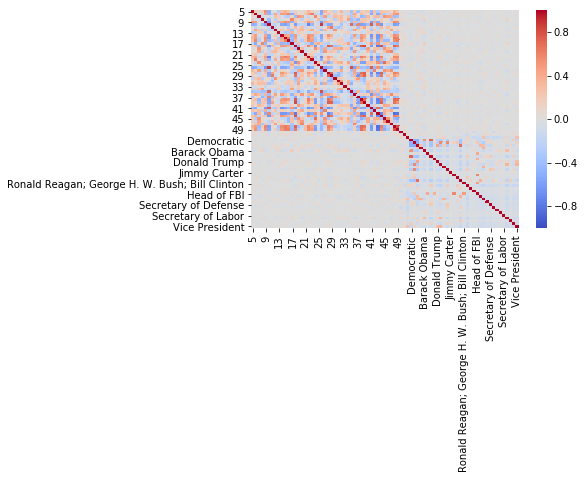

In [48]:
sns.heatmap(X_train.corr(), vmin=-1, vmax=1, cmap = 'coolwarm')

In [49]:
X_train

,0,5,6,7,8,9,10,11,12,13,...,Secretary of Commerce,Secretary of Defense,Secretary of HHS,Secretary of HUD,Secretary of Homeland Security,Secretary of Labor,Secretary of State,Secretary of Transportation,Secretary of the Treasury,Vice President
0,1861-03-04,0.028551,0.023626,0.024267,0.028181,0.090396,0.033834,0.011139,0.035884,0.014864,...,0,0,0,0,0,0,0,0,0,0
1,1861-03-04,0.032755,0.025122,0.020008,0.028696,0.074196,0.023390,0.010044,0.017153,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,1861-03-04,0.043313,0.029156,0.018179,0.033681,0.090177,0.035855,0.000000,0.018829,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,1861-03-04,0.043571,0.000000,0.043674,0.021920,0.088566,0.059971,0.011051,0.016486,0.011051,...,0,0,0,0,0,0,0,0,0,0
4,1861-03-04,0.034822,0.031805,0.018958,0.029756,0.079246,0.037021,0.014056,0.019057,0.012527,...,0,0,0,0,0,0,0,0,0,0
5,1861-03-04,0.047019,0.027529,0.016754,0.030670,0.094764,0.028841,0.000000,0.017148,0.000000,...,0,0,0,0,0,0,0,0,0,0
6,1861-03-04,0.030517,0.035100,0.019775,0.034301,0.082578,0.039938,0.000000,0.023458,0.000000,...,0,0,0,0,0,0,0,0,0,0
7,1861-03-04,0.035355,0.026585,0.015255,0.035968,0.096251,0.039874,0.000000,0.018007,0.016407,...,0,0,0,0,0,0,0,0,0,0
8,1861-03-04,0.032130,0.025354,0.022215,0.031276,0.077143,0.025891,0.011351,0.019496,0.000000,...,0,0,0,0,0,0,0,0,0,0
9,1861-03-04,0.028183,0.027699,0.022337,0.014238,0.075169,0.046446,0.000000,0.025562,0.012213,...,0,0,0,0,0,0,0,0,0,0


In [50]:
testing_merge = pd.merge(merged, df, left_on=[0,1,4], right_on=['Entered Office','Name','Role'])
testing_merge

,0,1,2,3,4,5,6,7,8,9,...,Secretary of the Treasury,Vice President,Entered Office,Exited Office,Name,Party,President_y,Role,collectionname,label
0,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.028551,0.023626,0.024267,0.028181,0.090396,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0
1,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.032755,0.025122,0.020008,0.028696,0.074196,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0
2,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.043313,0.029156,0.018179,0.033681,0.090177,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0
3,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.043571,0.000000,0.043674,0.021920,0.088566,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0
4,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.034822,0.031805,0.018958,0.029756,0.079246,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0
5,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.047019,0.027529,0.016754,0.030670,0.094764,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0
6,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.030517,0.035100,0.019775,0.034301,0.082578,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0
7,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.035355,0.026585,0.015255,0.035968,0.096251,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0
8,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.032130,0.025354,0.022215,0.031276,0.077143,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0
9,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.028183,0.027699,0.022337,0.014238,0.075169,...,0,0,1861-03-04,1865-04-15 00:00:00,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0


In [51]:
testing_merge['Edited Exited Office'] = testing_merge['Exited Office'].apply(lambda x: x.date() if type(x) == datetime.datetime else datetime.date(2020,1,1))

In [52]:
testing_merge['article_exit_delta'] = testing_merge['Edited Exited Office']-testing_merge[67]

In [53]:
testing_merge['within_month'] = testing_merge.article_exit_delta.apply(lambda x: 'Within One Month' if x<datetime.timedelta(30) else 'In Office')

In [54]:
testing_merge['within_week'] = testing_merge.article_exit_delta.apply(lambda x: 'Within One Week' if x<datetime.timedelta(8) else 'In Office')

In [55]:
testing_merge

,0,1,2,3,4,5,6,7,8,9,...,Name,Party,President_y,Role,collectionname,label,Edited Exited Office,article_exit_delta,within_month,within_week
0,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.028551,0.023626,0.024267,0.028181,0.090396,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,283 days,In Office,In Office
1,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.032755,0.025122,0.020008,0.028696,0.074196,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,484 days,In Office,In Office
2,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.043313,0.029156,0.018179,0.033681,0.090177,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,316 days,In Office,In Office
3,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.043571,0.000000,0.043674,0.021920,0.088566,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,447 days,In Office,In Office
4,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.034822,0.031805,0.018958,0.029756,0.079246,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,169 days,In Office,In Office
5,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.047019,0.027529,0.016754,0.030670,0.094764,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,281 days,In Office,In Office
6,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.030517,0.035100,0.019775,0.034301,0.082578,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,236 days,In Office,In Office
7,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.035355,0.026585,0.015255,0.035968,0.096251,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,541 days,In Office,In Office
8,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.032130,0.025354,0.022215,0.031276,0.077143,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,39 days,In Office,In Office
9,1861-03-04,abraham lincoln,Republican,Abraham Lincoln,President,0.028183,0.027699,0.022337,0.014238,0.075169,...,abraham lincoln,Republican,Abraham Lincoln,President,abrahamlincoln,0,1865-04-15,766 days,In Office,In Office


In [ ]:
y_month = testing_merge.within_month
y_week = testing_merge.within_week

In [ ]:
y_within_month_res = []
for i in range(len(list(testing_merge.article_exit_delta))):
    if list(testing_merge.label)[i] == 1 and list(testing_merge.within_month)[i] == 'Within One Month':
        y_within_month_res.append(1)
    else:
        y_within_month_res.append(0)

In [ ]:
y_within_week_res = []
for i in range(len(list(testing_merge.article_exit_delta))):
    if list(testing_merge.label)[i] == 1 and list(testing_merge.within_week)[i] == 'Within One Week':
        y_within_week_res.append(1)
    else:
        y_within_week_res.append(0)

In [ ]:
testing_merge['Week_Label'] = y_within_week_res

In [ ]:
testing_merge['Month_Label'] = y_within_month_res

In [ ]:
testing_merge.Month_Label.describe()

In [ ]:
#pd.to_pickle(testing_merge.Month_Label, 'data/y_train_month')
#pd.to_pickle(testing_merge.Week_Label, 'data/y_train_week')

In [ ]:
len(testing_merge[5].unique())

In [ ]:
y_month.describe()

In [ ]:
testing_merge

In [ ]:
testing_merge = testing_merge.sort_values(by=67)
testing_merge

In [ ]:
X_ordered = testing_merge.drop([2,3,4,'Name', 'Party',
                                'President_y', 'Role', 'collectionname', 'label',
                               'Edited Exited Office', 'article_exit_delta',
                               'within_month', 'within_week', 'Month_Label',
                               'Entered Office', 'Exited Office'],
                              axis=1)
X_ordered

In [ ]:
y_ordered = testing_merge.Month_Label
y_ordered

In [ ]:
X_ordered.groupby(by=1).count()[0]

In [ ]:
X_ordered.sort_values(by=[1,0])

In [ ]:
X_ordered['label'] = y_ordered
X_ordered.to_pickle('ordered_df.pkl')

In [ ]:
pol_series =[]
for name in X_ordered[1]:
    pol_series.append(X_ordered[X_ordered[1]==name])